<h2> An End-to-End Machine Learning Project </2>

<h3> The Problem </h3>
Model the district median house value in California Housing, given the CA census data. Since house value is numeric, this is a regression problem

<h3> Loading the Data </h3>
We will assume the data is provided as csv. You can also check the download_data notebook for Python code to download the data, or go to the site at https://github.com/ageron/handson-ml/tree/master/datasets/housing

In [6]:
import pandas as pd
import numpy as np

housing = pd.read_csv('housing.csv')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<h3> First Look into the Data </h3>
We surely need to have a first look at the data.

First, the dataset structure. We can use DataFrame.info() which will give the number of rows and columns, and column types.
- As shown, all columns are numeric (indicated by the float64 type) except for ocean_proximity which is class (indicated by the object type)
- Each row represents one district in CA
- Our target in this data is $median\_house\_value$

In [2]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


We use describe() to show statistics of all numeric columns. We can see 207 rows are missing total_bedrooms because the count of the column is 20433 compared to the total number of row of 20640.

In [3]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


We can observe their distributions with histograms

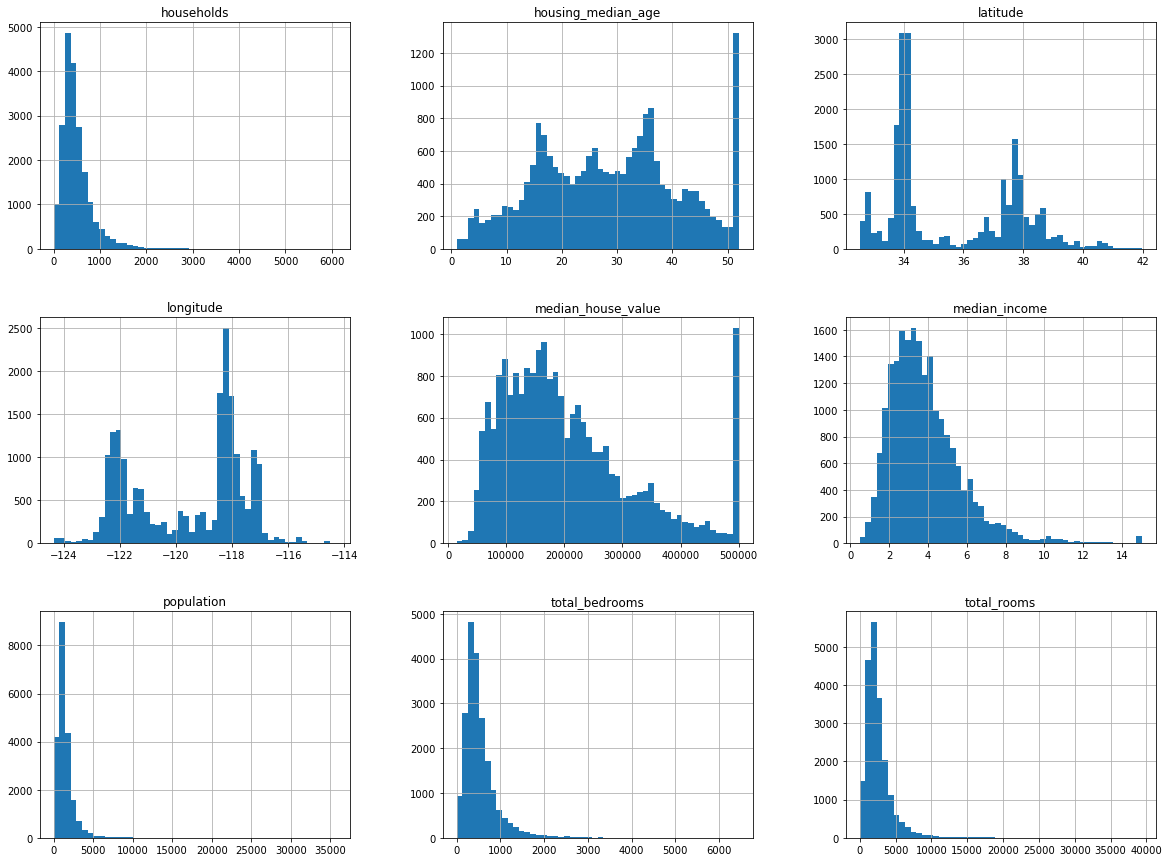

In [4]:
from matplotlib import pyplot as plt

housing.hist(bins=50, figsize=(20,15))
plt.show()

For the only class column - ocean_proximity - we can use a frequency table and a bar chart

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64


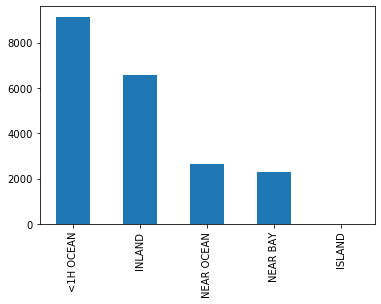

In [14]:
print(housing['ocean_proximity'].value_counts())

housing['ocean_proximity'].value_counts().plot.bar()

<h3> Train/Test Splitting </h3>

A quick look into the data is all you should done before train/test splitting. As discussed in module 3, overfitting can be a very severe problem which should be handled with train/test split.

This means, every steps, including data processing are done in the training set. The testing set will be kept untouch until we are ready to evaluate our models. 

For this problem, we will stratified the two sets by median income. However, median_income is a numeric column, so we can create a class column from it and stratify the split based on the new column. We will use pandas.cut()

In [7]:
housing["income_cat"] = pd.cut(housing["median_income"],              #the column to use for labeling
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],  #the ranges of the labels
                               labels=[1, 2, 3, 4, 5])                #the label 
                                                                      #overall: 
                                                                      # 0   <  median_income < 1.5 --> income_cat = 1
                                                                      # 1.5 <= median_income < 3.0 --> income_cat = 2
                                                                      # 3.0 <= median_income < 4.5 --> income_cat = 3
                                                                      # 4.5 <= median_income < 6.0 --> income_cat = 4
                                                                      # 6.0 <= median_income       --> income_cat = 5
                                                                            

In [8]:
#now we split using income_cat to stratify

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
#and we can drop the column afterward
strat_train_set.drop('income_cat', axis=1, inplace=True)
strat_test_set.drop('income_cat', axis=1, inplace=True)

We will drop the target column (median_house_value) from the input data, and store the label in a separate vector

In [9]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

After the step above, our training input data is housing, and our training label is housing_labels

<h3> Preprocessing the Training Data </h3>

Now we can create a Pipeline. A Pipeline allows us to applied different processes on the input data and obtain a single output. In this case, we will use a Pipeline to transform all numerics columns in the sequence of imputation to add new columns (using FunctionTransformer) to standardization. The syntax is as

<b>
    Pipeline([
    ('step 1 name', Step1Object), <br>
    ('step 2 name', Step1Object), <br> 
    ...                           <br>
    ('last step name', LastStepObject) <br>
    ])
</b>

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),                                       #first we impute using median
        ('std_scaler', StandardScaler()),                                                    #then standardizing
    ])

One last thing to do is to encode the only class column - ocean_proximity, and merge the numeric and class columns into a single input dataset. We will use <b>ColumnTransformer</b> to completely transform the original data to the ready-for-model data. Again, all numeric columns will be transformed with num_pipeline, and ocean_proximity will be transformed using OneHotEncoder

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

#we need a list of all numeric columns and a list of all class columns
attribs = list(housing)
cat_attribs = housing.columns[housing.dtypes==np.object]
num_attribs = housing.columns[housing.dtypes==np.number]


#now create a full pipeline with ColumnTransformers
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),         #'num' is the name of this step which applies num_pipeline on num_attribs
        ("cat", OneHotEncoder(), cat_attribs),      #'cat' is the name of this step which applies OneHotEncoder on cat_attribs
    ])

housing_prepared = full_pipeline.fit_transform(housing)  #and the prepared data

In [13]:
#a quick check on dimensionality
#remember, this is now a numpy array, not a Pandas DataFrame anymore
housing_prepared.shape

(16512, 16)

<h3> Try and Pick a Good Model </h3>
As the target is a numeric column, this is a regression problem. We will try several different models to pick a good one

- Linear regression
- Decision tree
- Random Forest

We will discuss all models later on, so don't worry if you are not familiar with them right now. 

So how do we compare the models? In regression problems like this, we will use mean squared error (MSE), and root mean squared error (RMSE) - which is similar to an average prediction error measurement. Surely we want more accurate models, which mean smaller error measurements are better

In [14]:
#we can import the function for mean_square_error here. We neet to square root it manually
from sklearn.metrics import mean_squared_error

Now we can try different models. SKLearn is a very easy package to learn. All model will have the below functions:
- fit(): fit a model on the given data (and label, if applicable). Also mean training the model
- predict(): predict the label of the given data using the fitted model

Note that for all models below, we are still not using testing data

<h4>Linear Regression</h4>

In [15]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()                                            #create a LinearRegression model
lin_reg.fit(housing_prepared, housing_labels)                           #fit the model

housing_predictions = lin_reg.predict(housing_prepared)                 #make prediction
lin_mse = mean_squared_error(housing_labels, housing_predictions)       #compute MSE
lin_rmse = np.sqrt(lin_mse)                                             #compute RMSE
lin_rmse

68628.19819848923

<h4>Decision Tree</h4>

In [16]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

An error measurement of 0 is very suspicious because it indicates a perfect model. It is very likely this model is overfitting.

<h4>Random Forest</h4>

In [17]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

21933.31414779769

<h4>Cross-Validation</h4>

As you have seen, testing the models directly on the data they were trained is not too useful. We can instead use k-fold cross-validation (k-cv). In brieft, in a k-cv process the data will be divided into k portions. Then, for each portion, the models are trained on the other (k-1) portions, and tested on the last ones. This means fitting the model k times. We then use the average errors of all runs to evaluate a model.

In [18]:
#we can import the cross-validation process here
from sklearn.model_selection import cross_val_score

In [19]:
#A simple function to print the mean scores and its standard deviation
def display_scores(scores):
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [20]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,     #cross validation for linear regression
                             scoring="neg_mean_squared_error", cv=10)       #test models in 10 folds 

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Mean: 69052.46136345083
Standard deviation: 2731.6740017983425


In [21]:
tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels,    #cross validation for decision tree model
                         scoring="neg_mean_squared_error", cv=10)

tree_rmse_scores = np.sqrt(-tree_scores)                                     #get RMSE from MSE 

display_scores(tree_rmse_scores)

Mean: 71407.68766037929
Standard deviation: 2439.4345041191004


In [22]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,   #cross validation for random forest
                                scoring="neg_mean_squared_error", cv=10)

forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Mean: 52583.72407377466
Standard deviation: 2298.353351147122


With cross-validation, we see that decision tree was clearing overfitting the data in the first test. The best model turned out to be random forest which obtains the least average RMSE in 10-fold cross-validation.

<h3> Finetune the Best Model </h3>
Usually, all models have a lot of hyper-parameters that can be changed to improve their performance (i.e. smaller prediction error). Hyperparameters are parameters that decide the <b>structure</b> of a model; it cannot be learned from data. Instead, we will tune it using a Grid Search or a Random Search. We will have a module about this later on.

<h4> Grid Search </h4>
In a grid search, we decide the hyper-parameter lists, and sklearn will fit a model for every combination. For random forest, we have two hyper parameters - n_estimators, and max_features. We will test 3, 10, and 30 estimators, and 2, 4, 6, 8 max_features. Best model is selected based on least error

In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
   ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

The best hyperparameter combination found:

In [24]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

<h4>Random Search</h4>

In a random search, we can define the <b>range of values</b> for the hyperparameters. SKLearn will randomly pick the combinations and train a model for each of them. Best model is selected based on least error.

In [25]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [26]:
rnd_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=7, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=180, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

<h4>Applying to Test Data</h4>

The best model can then be used on the test data. As we already have a pipeline, this step is very simple.

In [27]:
final_model1 = grid_search.best_estimator_                       #best model from grid search
final_model2 = rnd_search.best_estimator_                        #best model from random search

X_test = strat_test_set.drop("median_house_value", axis=1)       #similar to training data, we drop the label from input data
y_test = strat_test_set["median_house_value"].copy()             #and create a separate label dataset

X_test_prepared = full_pipeline.transform(X_test)                #transform input data using pipeline

final_predictions1 = final_model1.predict(X_test_prepared)       #prediction 
final_predictions2 = final_model2.predict(X_test_prepared)

final_mse1 = mean_squared_error(y_test, final_predictions1)      
final_rmse1 = np.sqrt(final_mse1)
print('grid search model: ', final_rmse1)

final_mse2 = mean_squared_error(y_test, final_predictions2)
final_rmse2 = np.sqrt(final_mse2)
print('random search model: ',final_rmse2)

grid search model:  47730.22690385927
random search model:  46910.92117024934


The random search model is slightly better in terms of RMSE. Is this difference practical though?

Finally, we can save/load the models to use later using joblib

In [29]:
from sklearn.externals import joblib
joblib.dump(final_model1, "final_model1.pkl")     #saving a model
#...
my_model_loaded = joblib.load("final_model1.pkl") #loading a model

<h3> An Illustration of the Whole Project </h3>

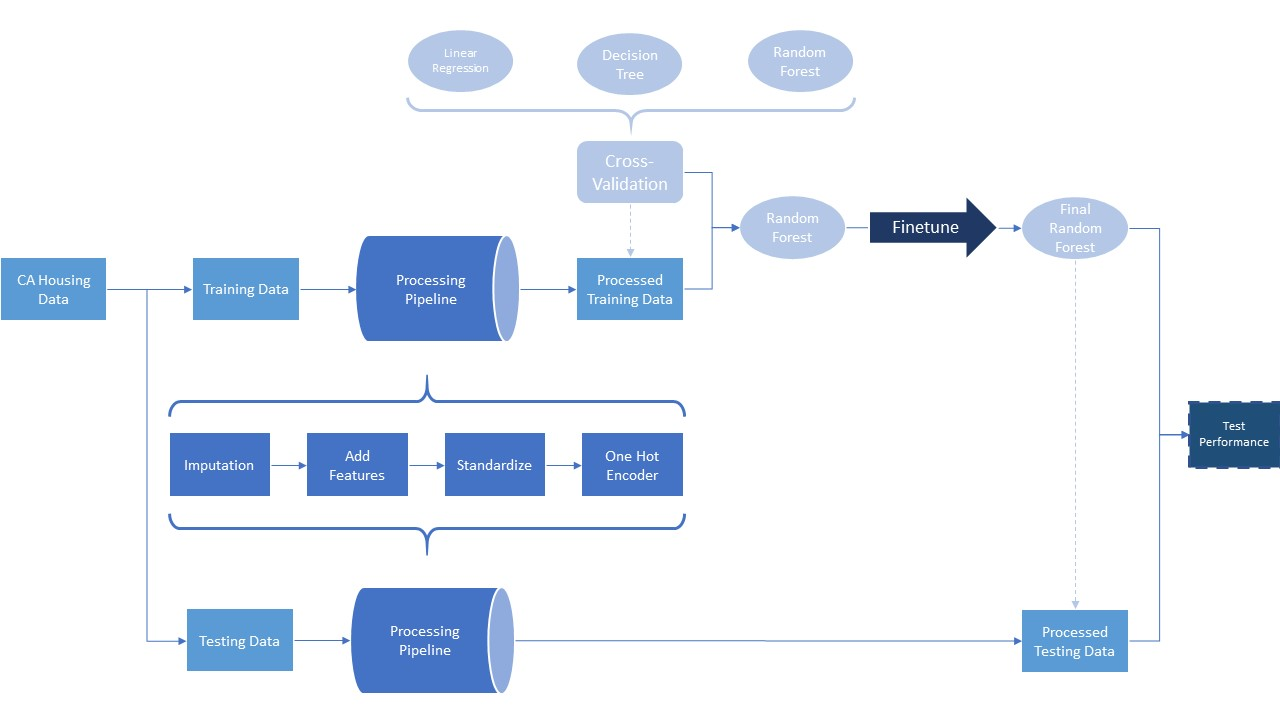